In [1]:
#! pip install matplotlib
#!pip install scipy

In [2]:
import os, warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
warnings.filterwarnings('ignore') 

In [3]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import scipy
import sys 
import time

# from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.discriminative_metrics2 import discriminative_score_metrics

# from metrics.predictive_metrics import predictive_score_metrics
from metrics.predictive_metrics2 import predictive_score_metrics

from metrics.visualization_metrics import visualization

In [6]:
orig_data_dir = "../data/processed_orig_data/"
gen_data_dir = "../data/generated_data/"

# Scaler

In [7]:
class MinMaxScaler():
    """Min Max normalizer.
    Args:
    - data: original data

    Returns:
    - norm_data: normalized data
    """
    def fit_transform(self, data): 
        self.fit(data)
        scaled_data = self.transform(data)
        return scaled_data


    def fit(self, data):    
        self.mini = np.min(data, 0)
        self.range = np.max(data, 0) - self.mini
        return self
        

    def transform(self, data):
        numerator = data - self.mini
        scaled_data = numerator / (self.range + 1e-7)
        return scaled_data

    
    def inverse_transform(self, data):
        data *= self.range
        data += self.mini
        return data

# Main Calculations

In [8]:
def confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Data: energy; Training Size: 2
ori_data shape:  (370, 24, 28) gen_data shape:  (18500, 24, 28)
------------------------------------------------------------------------------------------
Visualizations:


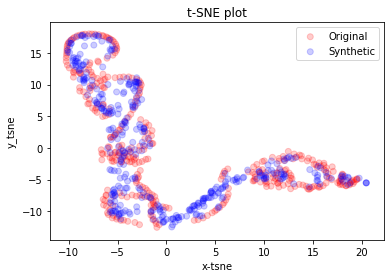

------------------------------------------------------------------------------------------
Predictive Score :
Avg. train / val loss for epoch 0: 0.096 / 0.05 
Avg. train / val loss for epoch 50: 0.032 / 0.032 
Avg. train / val loss for epoch 100: 0.031 / 0.031 
Avg. train / val loss for epoch 150: 0.03 / 0.032 
Avg. train / val loss for epoch 200: 0.029 / 0.03 
Avg. train / val loss for epoch 250: 0.029 / 0.029 
----------  pred iter:  0 score:  0.27041459128517753 ----------
Predictive score: 0.2704
Predictive score CI:  nan


------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Data: energy; Training Size: 5
ori_data shape:  (962, 24, 28) gen_data shape:  (19240, 24, 28)
------------------------------------------------------------------------------------------
Visualizations:


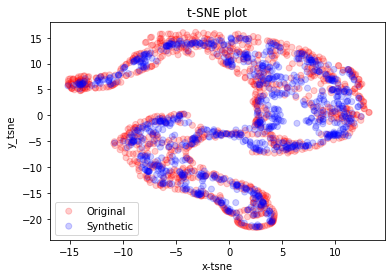

------------------------------------------------------------------------------------------
Predictive Score :
Avg. train / val loss for epoch 0: 0.061 / 0.031 


In [ ]:
start = time.time()

metric_iteration = 5

# full selection of data to run
training_sizes = [2, 5, 10, 20, 100]
datasets = ['sine', 'stocks', 'air', 'energy']


# custom selection 
# training_sizes = [ 2 ]
datasets = ['sine']

for dataset in datasets:

    for training_size in training_sizes:

        print('-'*90); print('-'*90)
        print(f"Data: {dataset}; Training Size: {training_size}")

        ## original data - always full data
        fname = f'{orig_data_dir + dataset}_subsampled_train_perc_{training_size}.npz'
        loaded = np.load(fname)
        ori_data = loaded['data']

        ## generated data is same size as full orig data, but generator was trained on sub sample of orig data
        sample_file_name = gen_data_dir + f'vae_conv_I_gen_samples_{dataset}_perc_{training_size}.npz'
        loaded = np.load(sample_file_name)
        gen_data = loaded['data']        
        
        ## scale orig and generated data
        scaler_orig = MinMaxScaler( )  
        scaled_ori_data = scaler_orig.fit_transform(ori_data)
        scaled_gen_data = scaler_orig.transform(gen_data) 
        
        print('ori_data shape: ', ori_data.shape, 'gen_data shape: ', gen_data.shape)
        #---------------------------------------------------------------------------
        print("-"*90); print('Visualizations:')
        # visualization(scaled_ori_data[0:scaled_gen_data.shape[0]], scaled_gen_data, 'pca')
        visualization(scaled_ori_data[0:scaled_gen_data.shape[0]], scaled_gen_data, 'tsne')

        #---------------------------------------------------------------------------
        print("-"*90); print('Discrimination Score :')
        discriminative_score = list()
        for tt in range(metric_iteration):
            temp_disc = discriminative_score_metrics(scaled_ori_data, scaled_gen_data,  epochs = 300)
            discriminative_score.append(temp_disc)  
            print("----------  disc iter: ", tt, 'score: ', temp_disc, '----------')

        print("-"*90); print('Discrimination Score :')
        print('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))
        print("Discriminative score CI: ", confidence_interval(discriminative_score)[1])

        #---------------------------------------------------------------------------             
        print("-"*90); print('Predictive Score :')
        predictive_score = list()
        for tt in range(metric_iteration):
            temp_pred = predictive_score_metrics(scaled_ori_data, scaled_gen_data, epochs = 300)
            predictive_score.append(temp_pred)   
            print("----------  pred iter: ", tt, 'score: ', temp_pred, '----------')
        print('Predictive score: ' + str(np.round(np.mean(predictive_score), 4)))
        print("Predictive score CI: ", confidence_interval(predictive_score)[1])

        print("\n")
        #---------------------------------------------------------------------------

end = time.time()
print(f"Total run time: {np.round((end - start)/60.0, 2)} minutes") 